# Convolutional Neural Network IMBD

Proyecto para Interpretación de sentimientos con Lenguaje Natural

## Librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import ngrams as nltk_ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('words')
english_words = set(words.words())
import re
import string

lemmatizer = WordNetLemmatizer()

from collections import Counter

ModuleNotFoundError: No module named 'matplotlib'

## Limpieza y preparación de Datos

In [3]:
df = pd.read_csv("./Data/IMDB Dataset.csv")
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [4]:
#Convertir sentimiento a bolean
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [5]:
#Proceso de limpieza de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()

    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)

    # Eliminar nombres propios
    text = re.sub(r'\b[A-Z][a-z]+(?:\'[a-z]+)?\b', '', text)

    # Eliminar frases entre comillas dobles
    text = re.sub(r'\".*?\"', '', text)

    # Eliminar contenido entre corchetes
    text = re.sub(r'\[.*?\]', '', text)

    # Eliminar puntuación
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Eliminar palabras con números
    text = re.sub(r'\w*\d\w*', '', text)

    # Eliminar caracteres repetidos
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Eliminar números
    text = re.sub(r'\d+', '', text)

    # Eliminar palabras muy largas o muy cortas
    text = ' '.join([word for word in text.split() if 2 <= len(word) <= 16])

    # Eliminar stopwords, conservando palabras específicas
    stop_words = set(stopwords.words('english'))
    keep_words = {'what', 'who', 'why', 'when', 'where', 'how'}  # Palabras importantes
    wordss = text.split()
    text = ' '.join([word for word in wordss if word not in stop_words or word in keep_words])

    # Filtrar palabras que contengan solo letras
    text = ' '.join([word for word in text.split() if word.isalpha()])

    # Filtrar palabras con prefijos anómalos
    text = ' '.join([word for word in text.split() if not word.startswith('aa')])
    # Lematización
    lemmatizerr = WordNetLemmatizer()
    text = ' '.join([lemmatizerr.lemmatize(word) for word in text.split()])

    return text


In [6]:
df_preprocessed = df.copy()

In [7]:
df_preprocessed['review'] = df_preprocessed['review'].apply(preprocess_text)

In [8]:
df_preprocessed.head(2)

,review,sentiment
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1


## EDA

### Generar bigramas

Creamos bigramas para hacer relación más rapidamente de las combinaciónes que definen un comentario positivo y negativo

In [9]:
 # Import ngrams and give it a unique name


In [10]:
def generate_ngrams(text, n):
    tokens = text.lower().split()
    n_grams = list(nltk_ngrams(tokens, n))  # Use the imported function
    return n_grams

n = 2  # You can change this to generate different n-grams (e.g., 3 for trigrams)
df_preprocessed['ngrams'] = df_preprocessed['review'].apply(lambda x: generate_ngrams(x, n))

# Separate ngrams by sentiment
positive_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 1 for ngram in ngrams_list]
negative_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 0 for ngram in ngrams_list]

In [11]:
df_preprocessed.head()

,review,sentiment,ngrams
0,one reviewer mentioned watching oz episode you...,1,"[(one, reviewer), (reviewer, mentioned), (ment..."
1,wonderful little production filming technique ...,1,"[(wonderful, little), (little, production), (p..."
2,thought wonderful way spend time hot summer we...,1,"[(thought, wonderful), (wonderful, way), (way,..."
3,basically there family where little boy jake t...,0,"[(basically, there), (there, family), (family,..."
4,petter matteis visually stunning film watch mr...,1,"[(petter, matteis), (matteis, visually), (visu..."


contar frecuencias

In [12]:
positive_ngram_counts = Counter(positive_ngrams)
negative_ngram_counts = Counter(negative_ngrams)


#### Calcular diferencia de frecuencias

Ayuda a evitar tener en cuenta ngramas que se repitan tanto en comentarios positivos como en negativos, los cuales no terminan siendo de mucha ayuda

In [13]:
'''
all_words = set(negative_ngram_counts.keys()).union(set(positive_ngram_counts.keys()))

# Crear un diccionario para las diferencias de frecuencias
frequency_differences = {}

for word in all_words:
    # Obtén la frecuencia de cada palabra en ambas listas, si no existe, asigna 0
    negative_freq = negative_ngram_counts.get(word, 0)
    positive_freq = positive_ngram_counts.get(word, 0)

    # Restar la frecuencia de las palabras
    frequency_differences[word] =  positive_freq - negative_freq

# Ordenar las palabras por la diferencia de frecuencias (de mayor a menor)
sorted_frequency_differences = sorted(frequency_differences.items(), key=lambda x: x[1], reverse=True)
'''

'\nall_words = set(negative_ngram_counts.keys()).union(set(positive_ngram_counts.keys()))\n\n# Crear un diccionario para las diferencias de frecuencias\nfrequency_differences = {}\n\nfor word in all_words:\n    # Obtén la frecuencia de cada palabra en ambas listas, si no existe, asigna 0\n    negative_freq = negative_ngram_counts.get(word, 0)\n    positive_freq = positive_ngram_counts.get(word, 0)\n\n    # Restar la frecuencia de las palabras\n    frequency_differences[word] =  positive_freq - negative_freq\n\n# Ordenar las palabras por la diferencia de frecuencias (de mayor a menor)\nsorted_frequency_differences = sorted(frequency_differences.items(), key=lambda x: x[1], reverse=True)\n'

### Análisis de bigramas

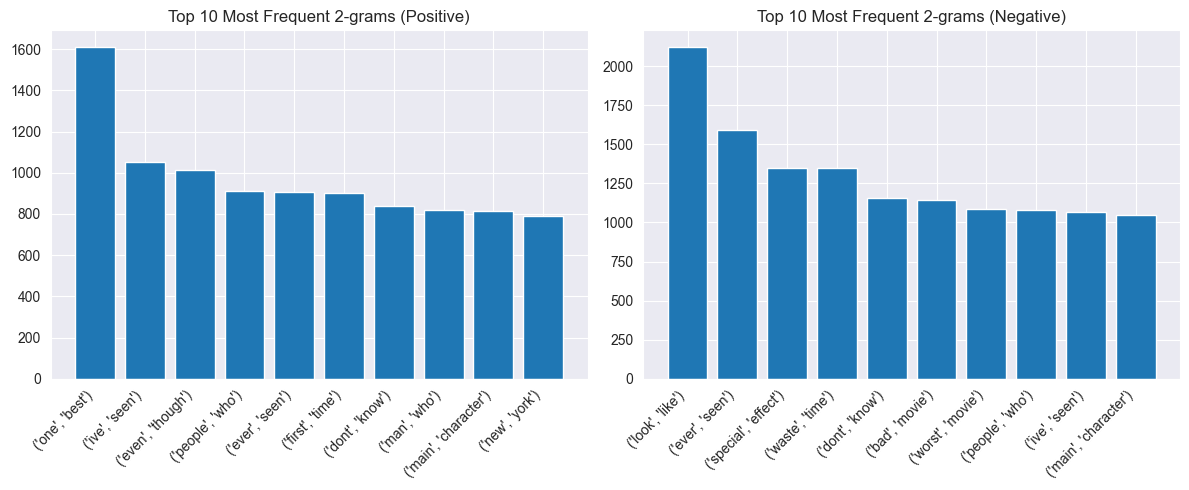

In [14]:
# graficar los mejores 10 ngramas por categoria
top_n = 10

top_positive_ngrams = positive_ngram_counts.most_common(top_n)
top_negative_ngrams = negative_ngram_counts.most_common(top_n)

#Prepare data for plotting
ngrams_pos = [str(ngram) for ngram, count in top_positive_ngrams]
counts_pos = [count for ngram, count in top_positive_ngrams]

ngrams_neg = [str(ngram) for ngram, count in top_negative_ngrams]
counts_neg = [count for ngram, count in top_negative_ngrams]



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(ngrams_pos, counts_pos)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Positive)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(ngrams_neg, counts_neg)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Negative)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Análisis por categorias

In [15]:
positive_reviews = df_preprocessed[df_preprocessed['sentiment'] == 1]['review']
negative_reviews = df_preprocessed[df_preprocessed['sentiment'] == 0]['review']

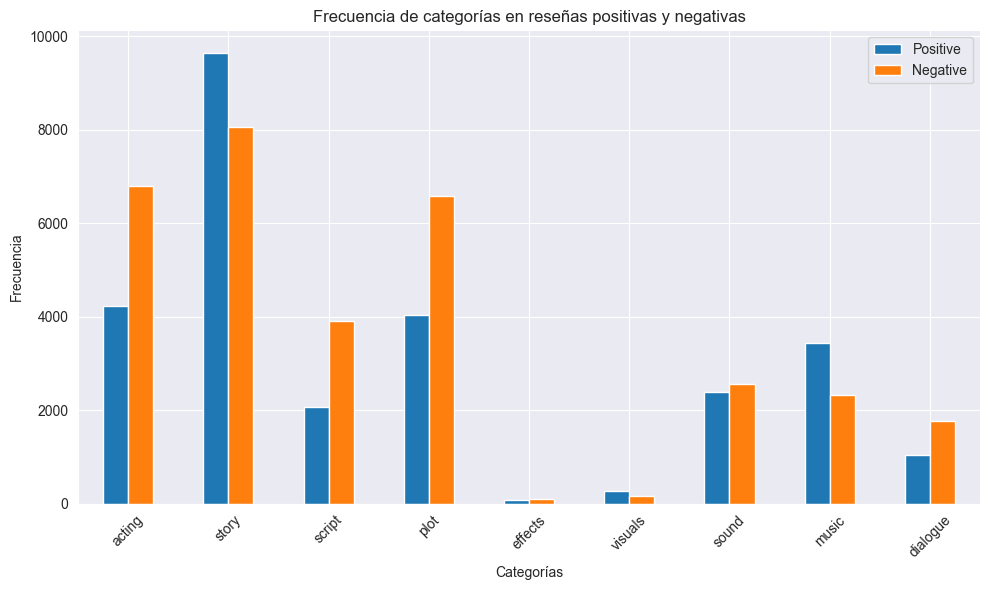

In [16]:
# Categorías clave a analizar
categories = ['acting', 'story', 'script', 'plot', 'effects', 'visuals', 'sound', 'music', 'dialogue']

# Función para buscar frecuencia de las categorías
def category_analysis(reviews, categories):
    frequencies = {}
    #examples = {}
    for category in categories:
        frequencies[category] = reviews.str.contains(category, case=False, na=False).sum()
    return frequencies

# reseñas positivas
positive_freq = category_analysis(positive_reviews, categories)

# reseñas negativas
negative_freq = category_analysis(negative_reviews, categories)

# Crear un DataFrame para frecuencias
freq_df = pd.DataFrame({'Positive': positive_freq, 'Negative': negative_freq})

# Gráfico de frecuencias
freq_df.plot(kind='bar', figsize=(10, 6))
plt.title('Frecuencia de categorías en reseñas positivas y negativas')
plt.ylabel('Frecuencia')
plt.xlabel('Categorías')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
'''import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('punkt_tab')

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')'''

"import nltk\nfrom nltk.tokenize import word_tokenize\nfrom nltk import pos_tag\nfrom nltk.corpus import stopwords\nfrom textblob import TextBlob\nimport matplotlib.pyplot as plt\nfrom scipy.stats import ttest_ind\n\n# Descargar recursos necesarios\nnltk.download('punkt')\nnltk.download('punkt_tab')\n\nnltk.download('averaged_perceptron_tagger')\nnltk.download('stopwords')\nnltk.download('averaged_perceptron_tagger_eng')"

In [18]:
'''
# Asume que el DataFrame tiene columnas: 'review' (texto) y 'sentiment' (positivo/negativo)
# Carga los datos
df = df_preprocessed.copy()  # Carga tus datos aquí

# Función para preprocesar y etiquetar partes del discurso
def pos_analysis(text):
    tokens = word_tokenize(text.lower())
    tags = pos_tag(tokens)
    return tags

# Función para contar categorías gramaticales
def count_pos_tags(pos_tags):
    counts = {"adjective": 0, "noun": 0, "verb": 0}
    for word, tag in pos_tags:
        if tag.startswith('JJ'):
            counts['adjective'] += 1
        elif tag.startswith('NN'):
            counts['noun'] += 1
        elif tag.startswith('VB'):
            counts['verb'] += 1
    return counts

# Aplicar el análisis POS y calcular emociones
pos_counts = {"positive": [], "negative": []}
emotion_scores = {"positive": [], "negative": []}

for _, row in df.iterrows():
    sentiment = row['sentiment']  # sentiment is 1 or 0
    review = row['review']
    pos_tags = pos_analysis(review)
    pos_count = count_pos_tags(pos_tags)

    # Convert sentiment to the corresponding key
    sentiment_key = "positive" if sentiment == 1 else "negative"

    # Guardar conteos de partes del discurso using sentiment_key
    pos_counts[sentiment_key].append(pos_count)

    # Analizar emociones
    polarity = TextBlob(review).sentiment.polarity
    emotion_scores[sentiment_key].append(polarity)

# Agregar análisis estadístico
def average_counts(counts_list):
    return {
        "adjective": sum(c['adjective'] for c in counts_list) / len(counts_list),
        "noun": sum(c['noun'] for c in counts_list) / len(counts_list),
        "verb": sum(c['verb'] for c in counts_list) / len(counts_list),
    }

positive_counts_avg = average_counts(pos_counts["positive"])
negative_counts_avg = average_counts(pos_counts["negative"])

# Comparar estadísticamente los resultados
positive_polarity = emotion_scores["positive"]
negative_polarity = emotion_scores["negative"]

# Prueba T para cada categoría gramatical
for category in ["adjective", "noun", "verb"]:
    positive_data = [c[category] for c in pos_counts["positive"]]
    negative_data = [c[category] for c in pos_counts["negative"]]
    stat, p_value = ttest_ind(positive_data, negative_data)
    print(f"{category.capitalize()} - T-test p-value: {p_value}")

# Comparación de emociones
stat, p_value = ttest_ind(positive_polarity, negative_polarity)
print(f"Emotion polarity - T-test p-value: {p_value}")

# Visualización
labels = ['Adjectives', 'Nouns', 'Verbs']
positive_values = [positive_counts_avg['adjective'], positive_counts_avg['noun'], positive_counts_avg['verb']]
negative_values = [negative_counts_avg['adjective'], negative_counts_avg['noun'], negative_counts_avg['verb']]

x = range(len(labels))
plt.bar(x, positive_values, width=0.4, label='Positive', align='center')
plt.bar(x, negative_values, width=0.4, label='Negative', align='edge')
plt.xticks(x, labels)
plt.ylabel('Average Count')
plt.title('POS Tag Comparison')
plt.legend()
plt.show()'''

'\n# Asume que el DataFrame tiene columnas: \'review\' (texto) y \'sentiment\' (positivo/negativo)\n# Carga los datos\ndf = df_preprocessed.copy()  # Carga tus datos aquí\n\n# Función para preprocesar y etiquetar partes del discurso\ndef pos_analysis(text):\n    tokens = word_tokenize(text.lower())\n    tags = pos_tag(tokens)\n    return tags\n\n# Función para contar categorías gramaticales\ndef count_pos_tags(pos_tags):\n    counts = {"adjective": 0, "noun": 0, "verb": 0}\n    for word, tag in pos_tags:\n        if tag.startswith(\'JJ\'):\n            counts[\'adjective\'] += 1\n        elif tag.startswith(\'NN\'):\n            counts[\'noun\'] += 1\n        elif tag.startswith(\'VB\'):\n            counts[\'verb\'] += 1\n    return counts\n\n# Aplicar el análisis POS y calcular emociones\npos_counts = {"positive": [], "negative": []}\nemotion_scores = {"positive": [], "negative": []}\n\nfor _, row in df.iterrows():\n    sentiment = row[\'sentiment\']  # sentiment is 1 or 0\n    revie

In [19]:
#df_preprocessed = df_preprocessed.drop('ngrams', axis=1)

# Preparación de datos tokenización

## Tokenización

In [20]:
# Descargar recursos necesarios para la tokenización
nltk.download('punkt')

# Ejemplo de texto: Puedes reemplazar esto con tus reseñas
df_preprocessed['tokens'] = df_preprocessed['review'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maico\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
df_preprocessed.head()

,review,sentiment,ngrams,tokens
0,one reviewer mentioned watching oz episode you...,1,"[(one, reviewer), (reviewer, mentioned), (ment...","[one, reviewer, mentioned, watching, oz, episo..."
1,wonderful little production filming technique ...,1,"[(wonderful, little), (little, production), (p...","[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,1,"[(thought, wonderful), (wonderful, way), (way,...","[thought, wonderful, way, spend, time, hot, su..."
3,basically there family where little boy jake t...,0,"[(basically, there), (there, family), (family,...","[basically, there, family, where, little, boy,..."
4,petter matteis visually stunning film watch mr...,1,"[(petter, matteis), (matteis, visually), (visu...","[petter, matteis, visually, stunning, film, wa..."


## Vectorización

# Embedings Preentrenados

In [22]:
'''import numpy as np
from gensim.models import KeyedVectors

# Ruta del archivo de embeddings preentrenados (asegúrate de tener el archivo)
# Descarga desde https://nlp.stanford.edu/projects/glove/ para GloVe o usa preentrenados de Word2Vec
word_vectors_path = '/content/glove.6B.300d.txt'

# Función para cargar embeddings GloVe
def load_glove_model(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Cargar embeddings
embeddings_index = load_glove_model(word_vectors_path)

# Función para convertir tokens a un vector promediado usando embeddings
def tokens_to_vector(tokens, embeddings_index):
    vectors = [embeddings_index[word] for word in tokens if word in embeddings_index]
    if len(vectors) == 0:
        return np.zeros(300)  # Vector nulo si no hay palabras conocidas
    return np.mean(vectors, axis=0)

# Convertir cada reseña a un vector
df_preprocessed['vector_glove'] = df_preprocessed['tokens'].apply(lambda x: tokens_to_vector(x, embeddings_index))

# Mostrar los primeros resultados
df_preprocessed[['review', 'vector_glove']].head()'''

"import numpy as np\nfrom gensim.models import KeyedVectors\n\n# Ruta del archivo de embeddings preentrenados (asegúrate de tener el archivo)\n# Descarga desde https://nlp.stanford.edu/projects/glove/ para GloVe o usa preentrenados de Word2Vec\nword_vectors_path = '/content/glove.6B.300d.txt'\n\n# Función para cargar embeddings GloVe\ndef load_glove_model(glove_file):\n    embeddings_index = {}\n    with open(glove_file, 'r', encoding='utf-8') as f:\n        for line in f:\n            values = line.split()\n            word = values[0]\n            vector = np.asarray(values[1:], dtype='float32')\n            embeddings_index[word] = vector\n    return embeddings_index\n\n# Cargar embeddings\nembeddings_index = load_glove_model(word_vectors_path)\n\n# Función para convertir tokens a un vector promediado usando embeddings\ndef tokens_to_vector(tokens, embeddings_index):\n    vectors = [embeddings_index[word] for word in tokens if word in embeddings_index]\n    if len(vectors) == 0:\n  

#TF-IDF

In [23]:
#from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
# Inicializar el vectorizador
#tfidf = TfidfVectorizer(max_features=1000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)

# Convertir las reseñas tokenizadas a una matriz TF-IDF
#tfidf_matrix = tfidf.fit_transform(df_preprocessed['tokens'])



In [25]:
# Guardar la matriz en el DataFrame (opcionalmente como una lista para cada reseña)
#df_preprocessed['vector_tfidf'] = list(tfidf_matrix.toarray())


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D,  Dense, Dropout,LSTM,Input
#GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Tokenización basada en Frecuencias

In [27]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_preprocessed['review'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_preprocessed['review'])

Conjuntos de Entrenamiento y Testeo

In [28]:
#padding
max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = df_preprocessed['sentiment'].values

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Embeddings de Glove

In [29]:
# Cargar GloVe
'''glove_path = '/content/glove.6B.300d.txt'

# Cargar embeddings de GloVe
embedding_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Crear la matriz de embeddings

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector'''

"glove_path = '/content/glove.6B.300d.txt'\n\n# Cargar embeddings de GloVe\nembedding_index = {}\nwith open(glove_path, 'r', encoding='utf-8') as f:\n    for line in f:\n        values = line.split()\n        word = values[0]\n        vector = np.asarray(values[1:], dtype='float32')\n        embedding_index[word] = vector\n\n# Crear la matriz de embeddings\n\nembedding_matrix = np.zeros((vocab_size, embedding_dim))\n\nfor word, i in word_index.items():\n    embedding_vector = embedding_index.get(word)\n    if embedding_vector is not None:\n        embedding_matrix[i] = embedding_vector"

# Creación NN Sin Embeddings Preentrenados

In [34]:
embedding_dim = 100
vocab_size = 50000

In [35]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True), #Embedings
    Conv1D(128, 5, activation='relu'),  #Convoluciones de 5 ngramas
    LSTM(128, return_sequences=False),  #Dependencias más largas
    #GlobalMaxPooling1D(),               #Activadores para priorizar relaciónes
    Dense(64, activation='relu'),       #Capa densa
    Dropout(0.2),                       #Evitar overfitting
    Dense(32, activation='relu'),       #Refina salida
    Dense(1, activation='sigmoid')  # Salida
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,206,081 (19.86 MB)

 Trainable params: 5,206,081 (19.86 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 217s 424ms/step - accuracy: 0.7566 - loss: 0.4851 - val_accuracy: 0.8624 - val_loss: 0.3257
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 266s 433ms/step - accuracy: 0.9117 - loss: 0.2430 - val_accuracy: 0.8626 - val_loss: 0.3141
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 264s 437ms/step - accuracy: 0.9507 - loss: 0.1511 - val_accuracy: 0.8601 - val_loss: 0.4189
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 287s 487ms/step - accuracy: 0.9725 - loss: 0.0898 - val_accuracy: 0.8629 - val_loss: 0.4788
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 232s 465ms/step - accuracy: 0.9848 - loss: 0.0551 - val_accuracy: 0.8625 - val_loss: 0.5871
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 455ms/step - accuracy: 0.9862 - loss: 0.0474 - val_accuracy: 0.8543 - val_loss: 0.5423
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 230s 460ms/step - accuracy: 0.9909 - loss: 0.0336 - val_accuracy: 0.8526 - val_loss: 0.6323
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 278s 556ms/step - accuracy: 0.9937 -

In [38]:
# Evaluar el modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to 0 or 1
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step
Accuracy on test set: 0.8596


In [36]:
# Hacer predicciones
y_predlr = model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step


In [38]:
# prompt: quiero convertir a y_predlr a cuanto el resutado sea mayor a 0.49 sea 1 y menor a o igual a 0

# Convertir las probabilidades a 0 o 1 según el umbral de 0.49
y_pred_binary = (y_predlr > 0.49).astype(int)

y_pred_binary

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]], shape=(10000, 1))

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Dividir los textos en positivos y negativos
positive_reviews = df[df['sentiment'] == 1]['review']
negative_reviews = df[df['sentiment'] == 0]['review']

# Vectorizar usando TF-IDF
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
positive_matrix = tfidf.fit_transform(positive_reviews)
negative_matrix = tfidf.fit_transform(negative_reviews)

# Extraer vocabulario y puntajes
positive_scores = pd.DataFrame(
    positive_matrix.toarray(), columns=tfidf.get_feature_names_out()
).mean().sort_values(ascending=False)

negative_scores = pd.DataFrame(
    negative_matrix.toarray(), columns=tfidf.get_feature_names_out()
).mean().sort_values(ascending=False)

# Mostrar las palabras más representativas
print("Palabras clave positivas:")
print(positive_scores.head(10))

print("\nPalabras clave negativas:")
print(negative_scores.head(10))


Palabras clave positivas:
final     0.102537
music     0.102390
live      0.045594
got       0.042636
try       0.041428
group     0.041264
stupid    0.040604
child     0.039112
rest      0.034448
matter    0.032481
dtype: float64

Palabras clave negativas:
movie        0.115430
film         0.093163
like         0.052624
bad          0.043443
character    0.040691
good         0.040622
time         0.039833
really       0.037147
make         0.036157
story        0.034525
dtype: float64


In [63]:
# Listas de palabras clave por aspecto
aspects = {
    'acting': ['acting', 'performance', 'actor', 'actress', 'cast'],
    'plot': ['plot', 'story', 'narrative', 'screenplay'],
    'visuals': ['visual', 'effects', 'cinematography', 'scenes', 'special effects'],
    'music': ['music', 'soundtrack', 'score', 'audio']
}

# Función para contar ocurrencias de palabras clave en un texto
def count_aspect_mentions(text, aspect_keywords):
    text = text.lower()  # Convertir a minúsculas
    return sum(1 for word in aspect_keywords if word in text)

# Crear columnas para cada aspecto
for aspect, keywords in aspects.items():
    df[aspect] = df['review'].apply(lambda x: count_aspect_mentions(x, keywords))

# Promediar menciones por polaridad
aspect_summary = df.groupby('sentiment')[list(aspects.keys())].mean()

print("Promedio de menciones por polaridad:")
print(aspect_summary)


Promedio de menciones por polaridad:
            acting     plot  visuals    music
sentiment                                    
0          0.79188  0.62360  0.06932  0.15532
1          0.77900  0.58636  0.09544  0.23020


In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary)}")

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

[[4372  589]
 [ 722 4317]]
Accuracy: 0.8689


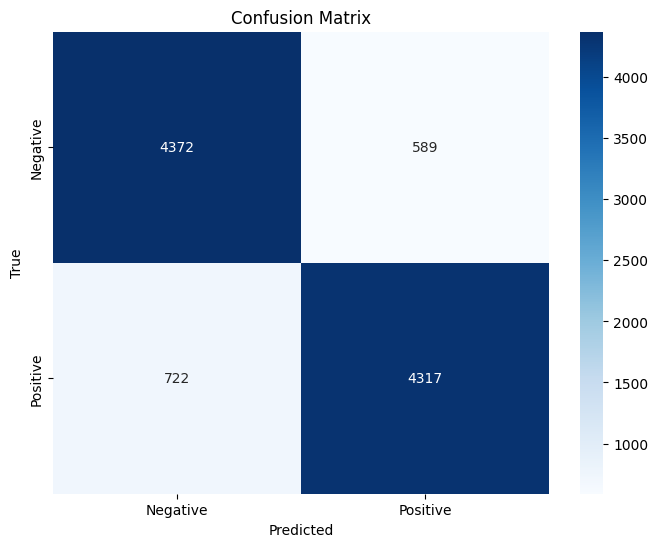

In [41]:
# prompt: GENERA MATRIZ DE CONFUNSION DE MANERA VISUAL

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

# Assuming y_test and y_pred_binary are defined from your model's prediction
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

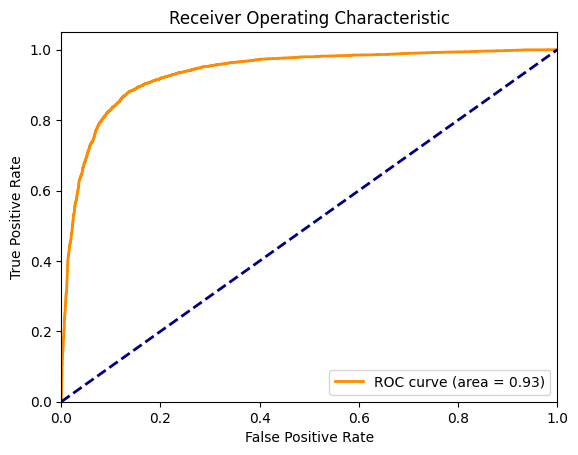

In [42]:
# prompt: genera Curvas ROC Para evaluar la capacidad del modelo para diferenciar entre clases positivas y negativas.

from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Assuming y_test contains the true labels and y_predlr contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_predlr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

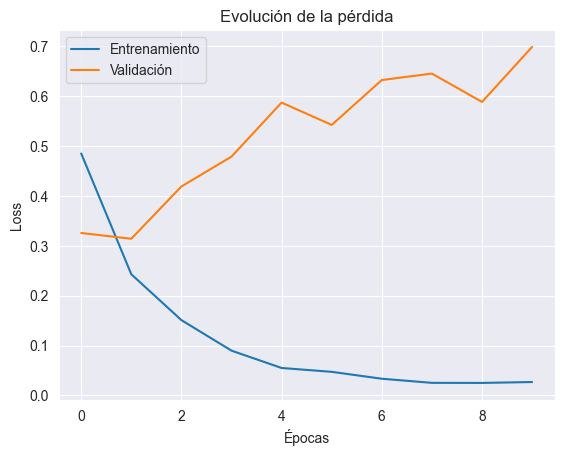

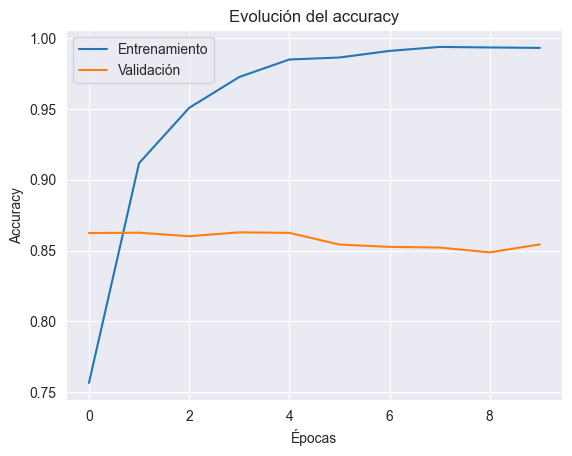

In [39]:
import matplotlib.pyplot as plt

# Gráfico de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfico de accuracy (si lo tienes en metrics)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Evolución del accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [45]:
df.shape

(50000, 2)